## SBrT 2024 - **An Introduction to Generative Artificial Intelligence with Applications in Telecommunications**

## Transformer Empowered CSI Feedback for Massive MIMO Systems

### This python notebook was based on the code at https://github.com/WilliamYangXu/CSITransformer/, that comes from the paper called: [Transformer Empowered CSI Feedback for Massive MIMO Systems](https://ieeexplore.ieee.org/abstract/document/9602863).

The objective of this notebook is show how the transformer architecture can be used to reconstruct CSI Feedback matrix.

## Load dataset
We have first to load the CSI matrix dataset, with 320000 samples, with dimension (320000, 2, 16, 32). Where the dimensions are, respectively, the sample ID, image channel, image height and image width. Furthermore, this consider a MIMO configuration with 32 antennas at Tx and 1 antenna at Rx, in a noiseless channel behavior.

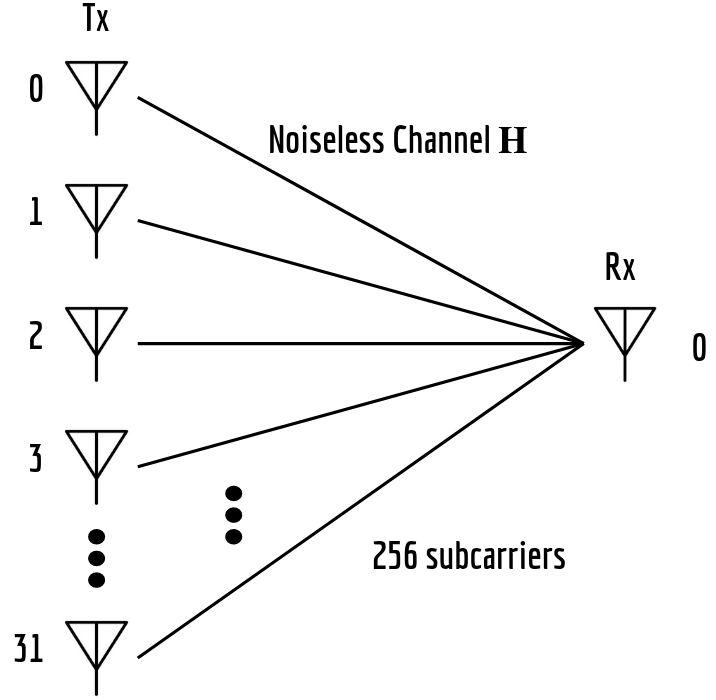

As follows, a visual example of a CSI matrix sample used to train the models:

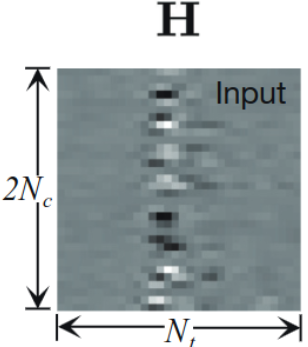

In [ ]:
!pip install wget

In [ ]:
import numpy as np
import h5py
import torch
from torch.utils.data import Dataset
import wget
import os

img_height = 16
img_width = 32
img_channels = 2

class DatasetFolder(Dataset):

    def __init__(self, matData):
        self.matdata = matData

    def __len__(self):
        return self.matdata.shape[0]

    def __getitem__(self, index):
        return self.matdata[index]

def load_data(
        file_path,
        shuffle = False,
        train_test_ratio=0.8,
        batch_size=32,
        num_workers=0,
        pin_memory=True,
        drop_last=True):

    if not os.path.isfile('Hdata.mat'):
        url_train_dataset = 'https://nextcloud.lasseufpa.org/s/tjkmy5d6TjyKJ68/download/Hdata.mat'
        filename = wget.download(url_train_dataset)

    print("loading data...")
    mat = h5py.File('Hdata.mat', 'r')
    data = np.transpose(mat['H_train'])
    data = data.astype('float32')
    data = np.reshape(data, [len(data), img_channels, img_height, img_width])

    if shuffle:
        data_copy = np.copy(data)
        data_transpose = data_copy.transpose()
        np.random.shuffle(data_transpose)
        data_shuffle = data_transpose.transpose()

    partition = int(data.shape[0] * train_test_ratio)
    x_train, x_test = data[:partition], data[partition:]
    x_train_shuffle, x_test_shuffle = data_shuffle[:partition], data_shuffle[partition:]

    # dataLoader for training
    train_dataset = DatasetFolder(x_train)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                               shuffle=True, num_workers=num_workers,
                                               pin_memory=pin_memory, drop_last=drop_last)
    # dataLoader for validating
    test_dataset = DatasetFolder(x_test)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                              shuffle=False, num_workers=num_workers, pin_memory=pin_memory)

    if shuffle:
        train_shuffle_dataset = DatasetFolder(x_train_shuffle)
        train_shuffle_loader = torch.utils.data.DataLoader(train_shuffle_dataset, batch_size=batch_size,
                                                  shuffle=False, num_workers=num_workers, pin_memory=pin_memory)

        test_shuffle_dataset = DatasetFolder(x_test_shuffle)
        test_shuffle_loader = torch.utils.data.DataLoader(test_shuffle_dataset, batch_size=batch_size,
                                                          shuffle=False, num_workers=num_workers, pin_memory=pin_memory)


        return train_loader, test_loader, train_dataset, test_dataset, train_shuffle_loader, test_shuffle_loader, train_shuffle_dataset, test_shuffle_dataset

    return train_loader, test_loader, train_dataset, test_dataset


## DL-based CSI Methods

Here we have all classes to construct the CSITransformer and MixedCSINet architectures.

In [ ]:
import torch.nn as nn
import torch
import torch.nn.functional as F
from collections import OrderedDict
import numpy as np

def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=True)

class ConvBN(nn.Sequential):
    def __init__(self, in_planes, out_planes, kernel_size, stride=1, groups=1):
        if not isinstance(kernel_size, int):
            padding = [(i - 1) // 2 for i in kernel_size]
        else:
            padding = (kernel_size - 1) // 2
        super(ConvBN, self).__init__(OrderedDict([
            ('conv', nn.Conv2d(in_planes, out_planes, kernel_size, stride,
                               padding=padding, groups=groups, bias=False)),
            ('bn', nn.BatchNorm2d(out_planes)),
            ('LeakyReLU', nn.LeakyReLU(negative_slope=0.3, inplace=False))
        ]))

class ConvBN_linear(nn.Sequential):
    def __init__(self, in_planes, out_planes, kernel_size, stride=1, groups=1):
        if not isinstance(kernel_size, int):
            padding = [(i - 1) // 2 for i in kernel_size]
        else:
            padding = (kernel_size - 1) // 2
        super(ConvBN_linear, self).__init__(OrderedDict([
            ('conv', nn.Conv2d(in_planes, out_planes, kernel_size, stride,
                               padding=padding, groups=groups, bias=False)),
            ('bn', nn.BatchNorm2d(out_planes))
        ]))

class ResBlock(nn.Module):
    def __init__(self, ch, nblocks=1, shortcut=True):
        super().__init__()
        self.shortcut = shortcut
        self.module_list = nn.ModuleList()
        for i in range(nblocks):
            resblock_one = nn.ModuleList()
            resblock_one.append(ConvBN(ch, 8, 3))
            resblock_one.append(ConvBN(8, 16, 3))
            resblock_one.append(ConvBN_linear(16, ch, 3))
            self.module_list.append(resblock_one)

    def forward(self, x):
        for module in self.module_list:
            h = x
            for res in module:
                h = res(h)
            x = x + h if self.shortcut else h
        return x

class PatchEmbed(nn.Module):
    def __init__(self, H=16, W=32, patch_size=4, in_chans=2, embed_dim=32):
        super().__init__()
        num_patches = H * W / patch_size ** 2
        self.img_size = [H, W]
        self.patch_size = [patch_size, patch_size]
        self.num_patches = num_patches
        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        x = self.proj(x).flatten(2).transpose(1, 2)
        return x

class FixedPositionalEncoding(nn.Module):
    def __init__(self, embedding_dim, max_length=5000):
        super(FixedPositionalEncoding, self).__init__()
        pe = torch.zeros(max_length, embedding_dim)
        position = torch.arange(0, max_length, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, embedding_dim, 2).float()
            * (-torch.log(torch.tensor(10000.0)) / embedding_dim)
        )
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[: x.size(0), :]
        return x

class TransformerEncoder(torch.nn.Module):
    # sbrt1_comment
    def __init__(self, embed_dim, num_heads, dropout, feedforward_dim):
        super().__init__()
        # init works to initialize all layer to be used in the forward function
        # initialize multihead attention with 32 and 8 heads
        self.attn = torch.nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout)
        self.linear_1 = torch.nn.Linear(embed_dim, feedforward_dim)
        self.linear_2 = torch.nn.Linear(feedforward_dim, embed_dim)
        self.layernorm_1 = torch.nn.LayerNorm(embed_dim)
        self.layernorm_2 = torch.nn.LayerNorm(embed_dim)

    def forward(self, x_in):
    # sbrt2_comment
        attn_out, _ = self.attn(x_in, x_in, x_in) # Q, K and V Matrices
        x = self.layernorm_1(x_in + attn_out)
        ff_out = self.linear_2(torch.nn.functional.relu(self.linear_1(x)))
        x = self.layernorm_2(x + ff_out)
        return x

class Csi_Encoder(nn.Module):

    def __init__(self, feedback_bits):
        super(Csi_Encoder, self).__init__()

        self.convban = nn.Sequential(OrderedDict([
            ("conv3x3_bn", ConvBN_linear(1, 2, 1)),
        ]))
        self.fc = nn.Linear(2048, int(feedback_bits))

    def forward(self, x_in):
        x_in = x_in.view(32,1,32,32)
        out = self.convban(x_in)
        out = out.view(32,-1)
        out = self.fc(out)
        return out

class Csi_Decoder(nn.Module):
    def __init__(self, feedback_bits):
        super(Csi_Decoder, self).__init__()

        self.feedback_bits = feedback_bits
        self.fc = nn.Linear(int(feedback_bits), 1024)
        decoder = OrderedDict([
            ("decoder1",ResBlock(1)),
            ('LeakyReLU', nn.LeakyReLU(negative_slope=0.3, inplace=False)),
            ("decoder2",ResBlock(1))
        ])
        self.decoder_feature = nn.Sequential(decoder)
        self.out_cov = ConvBN_linear(1,1,3)
        self.sig = nn.Sigmoid()

    def forward(self, x):
        out = x
        out = self.fc(out)
        out = out.view(32, 1, -1, 32)
        out = self.decoder_feature(out)
        out = self.out_cov(out)
        out = self.sig(out)
        out = out.view(32,2,16,32)
        return out

class Csi_Attention_Encoder(nn.Module):
    def __init__(self, feedback_bits):
        super(Csi_Attention_Encoder, self).__init__()
        self.conv_layer = ConvBN_linear(1,2,1)
        self.transformer_layer = nn.Sequential(OrderedDict([

                ("transformer_encoder1", TransformerEncoder(64,8,0,512))
            ])) # without positional encoding
        self.fc = nn.Linear(2048, int(feedback_bits))

    def forward(self, x_in):
        x_in = x_in.view(32,1,32,32)
        x_in = self.conv_layer(x_in)

        x_in = x_in.view(32,32,64)
        out = self.transformer_layer(x_in)
        out = out.contiguous().view(-1, 2048) # without pos encoding
        out = self.fc(out)
        return out

class Csi_Attention_Decoder(nn.Module):
    def __init__(self, feedback_bits):
        super(Csi_Attention_Decoder, self).__init__()

        self.feedback_bits = feedback_bits
        self.fc = nn.Linear(int(feedback_bits), 2048)
        decoder = OrderedDict([
            ("transformer_decoder1",TransformerEncoder(64,8,0,feedforward_dim=128))
        ])
        self.decoder_feature = nn.Sequential(decoder)
        self.conv_linear = ConvBN_linear(2,1,1)
        self.sig = nn.Sigmoid()

    def forward(self, x):
        out = x
        out = self.fc(out)
        out = out.view(32, -1, 64)
        out = self.decoder_feature(out)
        out = out.view([32,2,32,32])
        out = self.conv_linear(out)
        out = self.sig(out)
        out = out.view(32,2,16,32)
        return out

class Csi_Net(nn.Module):
    def __init__(self, feedback_bits):
        super(Csi_Net, self).__init__()
        self.encoder = Csi_Encoder(feedback_bits)
        self.decoder = Csi_Decoder(feedback_bits)

    def forward(self, x):
        feature = self.encoder(x)
        out = self.decoder(feature)
        return out

class Csi_Transformer_Net(nn.Module):
    def __init__(self, feedback_bits):
        super(Csi_Transformer_Net, self).__init__()
        self.encoder = Csi_Attention_Encoder(feedback_bits)
        self.decoder = Csi_Attention_Decoder(feedback_bits)

    def forward(self, x):
        feature = self.encoder(x)
        out = self.decoder(feature)
        return out

class CS_Net(nn.Module):
    def __init__(self, feedback_bits):
        super(CS_Net, self).__init__()
        self.A = np.random.uniform(low=-0.5, high=0.5, size=(1024, feedback_bits))
        self.A = torch.from_numpy(self.A)
        self.A = self.A.float()
        self.decoder = Csi_Decoder(feedback_bits)

    def forward(self, x):

        x = x.view(32, -1)
        out = x @ self.A
        out = out
        out = self.decoder(out)
        return out

class Csi_CNN_Transformer_Net(nn.Module):
    def __init__(self, feedback_bits):
        super(Csi_CNN_Transformer_Net, self).__init__()
        self.encoder = Csi_Encoder(feedback_bits)
        self.decoder = Csi_Attention_Decoder(feedback_bits)

    def forward(self, x):
        feature = self.encoder(x)
        out = self.decoder(feature)
        return out

## Image Segmentation

In [ ]:
import numpy as np
import matplotlib as plt
import torch
import os
import torch.nn as nn
import random
import time

import matplotlib.pyplot as plt

gpu_list = '0'
os.environ["CUDA_VISIBLE_DEVICES"] = gpu_list


def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

def channel_visualization(image):
    fig, ax = plt.subplots()
    ax.imshow(image, cmap=plt.cm.gray, interpolation='nearest', origin='upper')
    ax.spines['left'].set_position(('outward', 10))
    ax.spines['bottom'].set_position(('outward', 10))
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    plt.show()

SEED = 42
print("seeding everything...")
seed_everything(SEED)
print("initializing parameters...")


class model_trainer():

    def __init__(self,
                 epochs,
                 net,
                 feedbackbits=128,
                 batch_size=32,
                 learning_rate=1e-3,
                 lr_decay_freq=30,
                 lr_decay=0.1,
                 best_loss=100,
                 num_workers=0,
                 print_freq=100,
                 train_test_ratio=0.8):

        self.epochs = epochs
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.lr_decay_freq = lr_decay_freq
        self.lr_decay = lr_decay
        self.best_loss = best_loss
        self.num_workers = num_workers
        self.print_freq = print_freq
        self.train_test_ratio = train_test_ratio

        # parameters for data
        self.feedback_bits = feedbackbits
        self.img_height = 16
        self.img_width = 32
        self.img_channels = 2

        self.model = eval(net)(self.feedback_bits)
        self.x_label = []
        self.y_label = []
        self.ys_label = []
        self.t_label = []

        if len(gpu_list.split(',')) > 1:
            self.model = torch.nn.DataParallel(self.model)  # model.module
        else:
            self.model = self.model

        self.criterion = NMSELoss(reduction='mean')  # nn.MSELoss()
        self.criterion_test = NMSELoss(reduction='sum')
        self.optimizer = torch.optim.AdamW(self.model.parameters(), lr=self.learning_rate)

        self.train_loader, self.test_loader, self.train_dataset, \
            self.test_dataset, self.train_shuffle_loader, self.test_shuffle_loader, \
                self.train_shuffle_dataset, self.test_shuffle_dataset = load_data('/filepath',shuffle = True)

    def model_save(self,encoderPATH, decoderPATH):
        print('Saving model...')

        try:
            torch.save({'state_dict': self.model.encoder.state_dict(), }, '/filepath')
        except:
            torch.save({'state_dict': self.model.module.encoder.state_dict(), }, '/filepath')

        try:
            torch.save({'state_dict': self.model.decoder.state_dict(), }, '/filepath')
        except:
            torch.save({'state_dict': self.model.module.decoder.state_dict(), }, '/filepath')
#         print('Model saved!')
        self.best_loss = self.average_loss

    def model_train(self):

        for epoch in range(self.epochs):
            print('========================')
            print('lr:%.4e' % self.optimizer.param_groups[0]['lr'])
            # train model
            self.model.train()

            # decay lr
            if epoch % self.lr_decay_freq == 0 and epoch > 0:
                self.optimizer.param_groups[0]['lr'] = self.optimizer.param_groups[0]['lr'] * self.lr_decay

            # training...
            for i, input in enumerate(self.train_loader):
                input = input  # input [batch=32,2,16,32]
                output = self.model(input)
                loss = self.criterion(output, input)
                loss.backward()
                self.optimizer.step()
                self.optimizer.zero_grad()
                if i % self.print_freq == 0:
                    print('Epoch: [{0}][{1}/{2}]\t'
                          'Loss {loss:.4f}\t'.format(
                        epoch, i, len(self.train_loader), loss=loss.item()))
            self.model.eval()

            # evaluating...
            self.total_loss = 0
            self.total_rho = 0
            start = time.time()
            with torch.no_grad():

                for i, input in enumerate(self.test_loader):

                    input = input
                    output = self.model(input)
                    self.total_loss += self.criterion_test(output, input).item()
                    # self.total_rho += self.criterion_rho(output,input).item()
                    #print(rho(output,input), type(rho(output,input)))
                    self.total_rho += (rho(output,input))

                end = time.time()
                t = end - start
                self.average_loss = self.total_loss / len(self.test_dataset)
                self.average_rho = self.total_rho / len(list(enumerate(self.test_loader)))
                self.x_label.append(epoch)
                self.y_label.append(self.average_loss)
                self.t_label.append(t)
                print('NMSE %.4f ρ %.3f time %.3f' % (self.average_loss,self.average_rho, t))

        for i, input in enumerate(self.test_loader): # visualize one sample
            if i == 3: # set shuffle = False to ensure the same sample each time
                ones = torch.ones(32,32)
                image1 = input[0].view(32,32)
                image1 = ones - image1
                image1 = image1.numpy()
                channel_visualization(image1)
                input = input
                output = self.model(input)
                output = output.cpu()
                image2 = output[0].view(32,32)
                image2 = ones - image2
                image2 = image2.detach().numpy()
                channel_visualization(image2)

        return self.x_label, self.y_label, sum(self.t_label)/len(self.t_label) # , self.ys_label


## Loss function and Metrics

In [ ]:
def NMSE(x, x_hat):
    x_real = np.reshape(x[:, :, :, 0], (len(x), -1))
    x_imag = np.reshape(x[:, :, :, 1], (len(x), -1))
    x_hat_real = np.reshape(x_hat[:, :, :, 0], (len(x_hat), -1))
    x_hat_imag = np.reshape(x_hat[:, :, :, 1], (len(x_hat), -1))
    x_C = x_real - 0.5 + 1j * (x_imag - 0.5)
    x_hat_C = x_hat_real - 0.5 + 1j * (x_hat_imag - 0.5)
    power = np.sum(abs(x_C) ** 2, axis=1)
    mse = np.sum(abs(x_C - x_hat_C) ** 2, axis=1)
    nmse = np.mean(mse / power)
    return nmse

def NMSE_cuda(x, x_hat):
    x_real = x[:, 0, :, :].view(len(x), -1) - 0.5
    x_imag = x[:, 1, :, :].view(len(x), -1) - 0.5
    x_hat_real = x_hat[:, 0, :, :].contiguous().view(len(x_hat), -1) - 0.5
    x_hat_imag = x_hat[:, 1, :, :].contiguous().view(len(x_hat), -1) - 0.5
    power = torch.sum(x_real ** 2 + x_imag ** 2, axis=1)
    mse = torch.sum((x_real - x_hat_real) ** 2 + (x_imag - x_hat_imag) ** 2, axis=1)
    nmse = mse / power
    return nmse

class NMSELoss(nn.Module):
    def __init__(self, reduction='sum'):
        super(NMSELoss, self).__init__()
        self.reduction = reduction

    def forward(self, x_hat, x):
        nmse = NMSE_cuda(x, x_hat)
        if self.reduction == 'mean':
            nmse = torch.mean(nmse)
        else:
            nmse = torch.sum(nmse)
        return nmse

def rho(x, x_hat):
    x_real = x[:, 0, :, :].view(len(x), -1) - 0.5
    x_imag = x[:, 1, :, :].view(len(x), -1) - 0.5
    x_hat_real = x_hat[:, 0, :, :].contiguous().view(len(x_hat), -1) - 0.5
    x_hat_imag = x_hat[:, 1, :, :].contiguous().view(len(x_hat), -1) - 0.5

    cos = nn.CosineSimilarity(dim=1, eps=0)
    out_real = cos(x_real,x_hat_real)
    out_imag = cos(x_imag, x_hat_imag)
    result_real = out_real.sum() / len(out_real)
    reault_imag = out_imag.sum() / len(out_imag)
    return 0.5*(result_real + reault_imag)

class CosSimilarity(nn.Module):
    def __init__(self, reduction='sum'):
        super(CosSimilarity, self).__init__()
        self.reduction = reduction

    def forward(self, x_hat, x):
        cos = rho(x, x_hat)

        return cos


## Training CSITransformer

The CSITransformer considering the encoder-decoder transformer, as shown below.
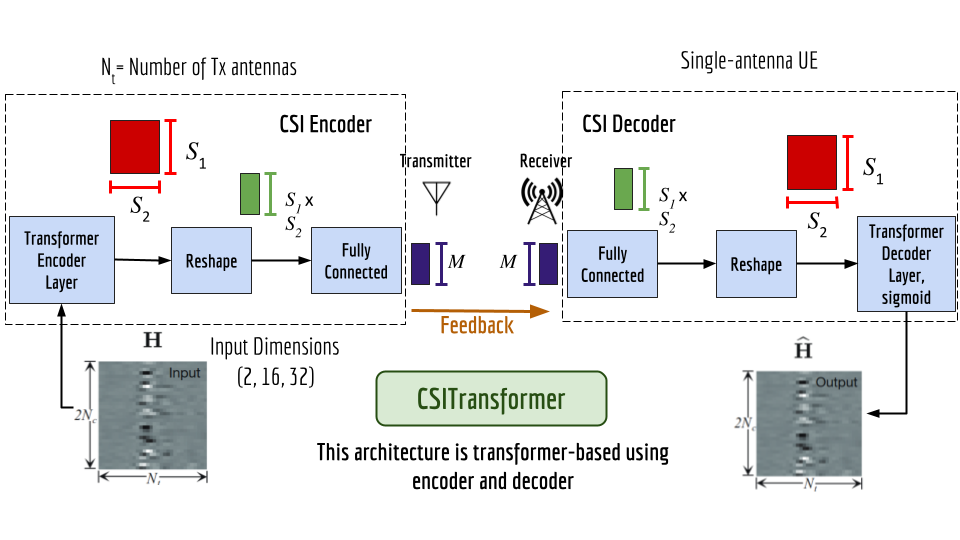



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import torch
import os
import torch.nn as nn
import random

gpu_list = '0'
os.environ["CUDA_VISIBLE_DEVICES"] = gpu_list

def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

SEED = 42
seed_everything(SEED)

def train_all(bits):
    print("="*30)
    print("Encoder: transformer; Decoder: transformer")
    print("compressed codeword bits: {}".format(bits))
    # In the paper the number of epochs used was 40
    agent1 = model_trainer(epochs=10, net="Csi_Transformer_Net",feedbackbits=bits)
    x1, agent1_NMSE, t1 = agent1.model_train()
    print("Csi_Transformer_Net")
    print(agent1_NMSE)
    print("average time used is:", t1)
    train_all(128)
    plt.plot(x1, agent1_NMSE, label="Csi_Transformer_Net")
    plt.xlabel("Number of Epochs")
    plt.ylabel("NMSE")
    plt.show()

train_all(128)

## Training MixedCSINet

The MixedCSINet considers a CNN model as encoder, and the transformer'decoder structure, as shown below.
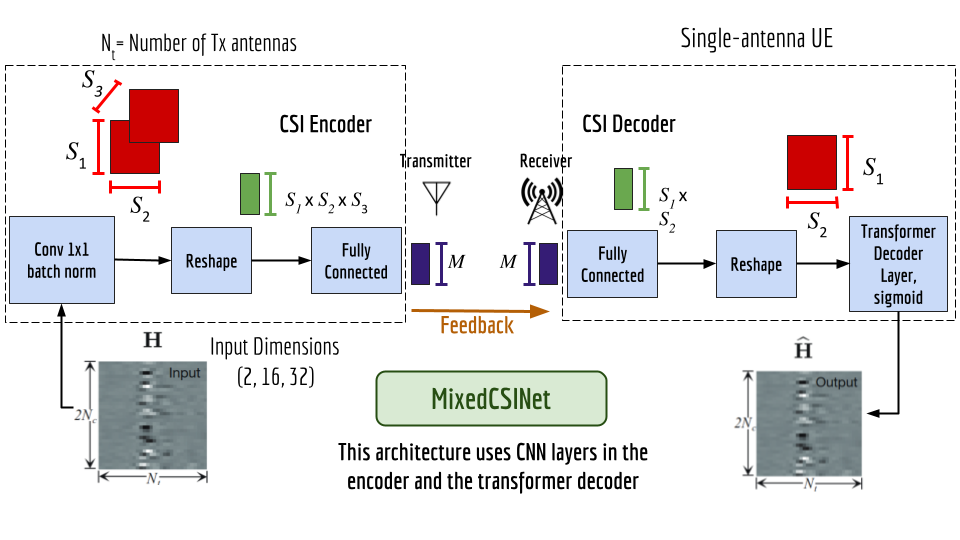

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import torch
import os
import torch.nn as nn
import random

gpu_list = '0'
os.environ["CUDA_VISIBLE_DEVICES"] = gpu_list

def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

SEED = 42
seed_everything(SEED)

def train_all(bits):
    print("="*30)
    print("Encoder: CNN; Decoder: transformer")
    print("compressed codeword bits: {}".format(bits))
    # In the paper the number of epochs is 40
    agent2 = model_trainer(epochs=10, net="Csi_CNN_Transformer_Net",feedbackbits=bits)
    x2, agent2_NMSE, t2 = agent2.model_train()
    print("Csi_CNN_Transformer_Net")
    print(agent2_NMSE)
    print("average time used is:", t2)
    plt.plot(x2, agent2_NMSE, label="Csi_CNN_Transformer_Net")
    plt.xlabel("Number of Epochs")
    plt.ylabel("NMSE")
    plt.show()
    print(x2)


train_all(128)

# CSI reconstruct quality in comparison with original sample

In this case, for different compression rate.

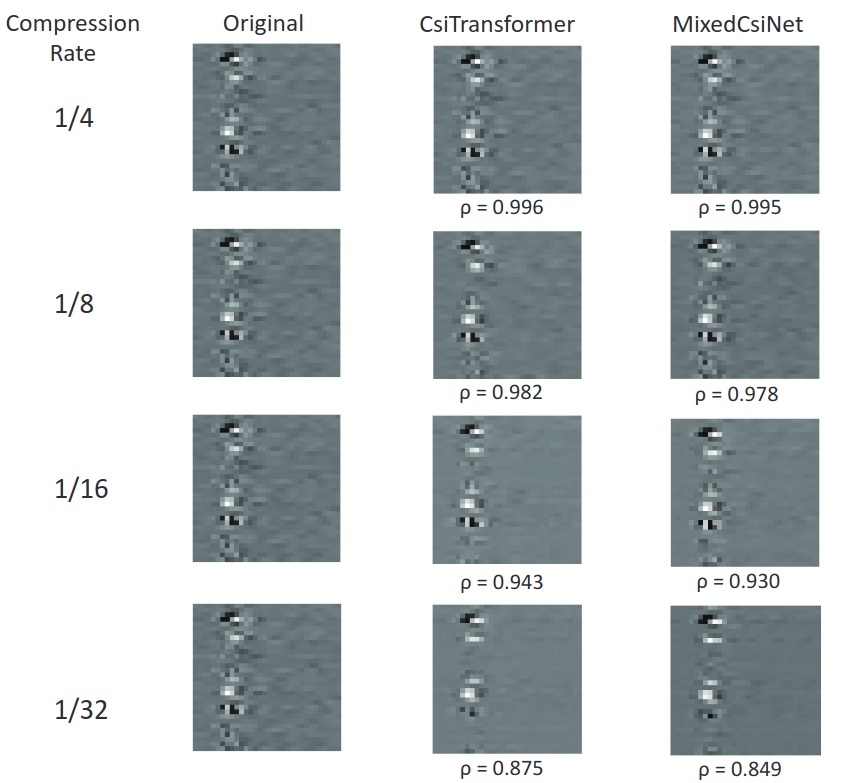